In [ ]:
!pip install pycocotools



COCO Dataset Ready!
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
Detected Labels: ['bottle', 'dining table', 'person', 'knife', 'bowl', 'bowl', 'oven', 'person', 'cup', 'cup', 'bowl', 'bowl', 'broccoli', 'spoon', 'broccoli', 'broccoli', 'oven', 'carrot', 'sink']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

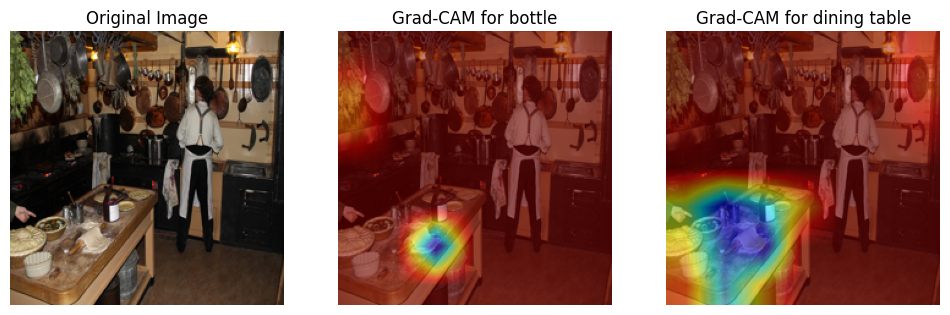

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import requests
import os
import zipfile

# === Download COCO 2017 Dataset (If Not Exists) ===
coco_dir = "/content/coco"
if not os.path.exists(coco_dir):
    os.makedirs(coco_dir)

# Download Annotations
ann_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
ann_path = os.path.join(coco_dir, "annotations.zip")

if not os.path.exists(os.path.join(coco_dir, "annotations")):
    print("Downloading COCO Annotations...")
    r = requests.get(ann_url, stream=True)
    with open(ann_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    # Extract ZIP
    print("Extracting Annotations...")
    with zipfile.ZipFile(ann_path, 'r') as zip_ref:
        zip_ref.extractall(coco_dir)
    os.remove(ann_path)

# Download COCO 2017 Validation Images (~800MB)
img_url = "http://images.cocodataset.org/zips/val2017.zip"
img_path = os.path.join(coco_dir, "val2017.zip")

if not os.path.exists(os.path.join(coco_dir, "val2017")):
    print("Downloading COCO Validation Images...")
    r = requests.get(img_url, stream=True)
    with open(img_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    # Extract ZIP
    print("Extracting Images...")
    with zipfile.ZipFile(img_path, 'r') as zip_ref:
        zip_ref.extractall(coco_dir)
    os.remove(img_path)

print("COCO Dataset Ready!")

# === Load COCO Data ===
coco_path = os.path.join(coco_dir, "annotations/instances_val2017.json")
coco = COCO(coco_path)

# Select a random image with multiple labels
image_ids = coco.getImgIds()
img_data = coco.loadImgs(image_ids[0])[0]  # Change index for different image
image_path = os.path.join(coco_dir, "val2017", img_data["file_name"])
image = Image.open(image_path).convert("RGB")

# Get labels for this image
ann_ids = coco.getAnnIds(imgIds=img_data["id"])
annotations = coco.loadAnns(ann_ids)
labels = [coco.loadCats(ann['category_id'])[0]['name'] for ann in annotations]
print("Detected Labels:", labels)

# === Transform Image for Model ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# === Load a Pretrained Model (ResNet-50) ===
model = models.resnet50(pretrained=True)
model.eval()

# === Get Last Conv Layer for Grad-CAM ===
target_layer = model.layer4[-1]

# === Define Grad-CAM ===
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        # Hook to capture activations and gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activation.detach().cpu().numpy()

        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.sum(weights[:, :, None, None] * activations, axis=1)[0]  # Weighted sum
        cam = np.maximum(cam, 0)  # ReLU

        # Normalize and resize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cv2.resize(cam, (224, 224))

        return cam

# === Initialize Grad-CAM ===
grad_cam = GradCAM(model, target_layer)

# === Run Grad-CAM for Multiple Labels in Image ===
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Convert PIL image to numpy
image_np = np.array(image.resize((224, 224)))

# Show original image
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate Grad-CAM for each label
for i, label in enumerate(labels[:2]):  # Only showing first two labels
    target_class = i  # Dummy class index (Replace with real COCO class index if needed)

    heatmap = grad_cam.generate_cam(input_tensor, target_class)

    # Apply heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    axes[i+1].imshow(overlay)
    axes[i+1].set_title(f"Grad-CAM for {label}")
    axes[i+1].axis("off")

plt.show()


In [ ]:
import os

train_images_path = os.path.join(coco_dir, "train2017")
if not os.path.exists(train_images_path):
    print("⚠️ train2017 images not found! Please download them first.")


# Find an image with an animal
animal_cats = [17, 18, 19, 20, 21, 22]  # COCO IDs for cat, dog, horse, cow, elephant, bea
coco_train = COCO(os.path.join(coco_dir, "annotations", "instances_train2017.json"))
img_ids = coco_train.getImgIds(catIds=animal_cats)
print(f"Animal images in train2017: {len(img_ids)}")
img_ids = coco_train.getImgIds(catIds=animal_cats)
img_data = coco_train.loadImgs(img_ids[0])[0]  # Pick first match

# Load the image
image_path = os.path.join(coco_dir, "train2017", img_data["file_name"])
image = Image.open(image_path).convert("RGB")

# Get annotations
ann_ids = coco_train.getAnnIds(imgIds=img_data["id"])
annotations = coco_train.loadAnns(ann_ids)
labels = [coco_train.loadCats(ann['category_id'])[0]['name'] for ann in annotations]
category_ids = [ann['category_id'] for ann in annotations]

print("Detected Labels:", labels)
fig, axes = plt.subplots(1, len(labels) + 1, figsize=(12, 4))

# Convert PIL image to numpy
image_np = np.array(image.resize((224, 224)))

# Show original image
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate Grad-CAM for each detected animal
for i, (label, cat_id) in enumerate(zip(labels, category_ids)):
    # Map COCO category ID to ImageNet class (Rough approximation)
    target_class = cat_id % 1000

    heatmap = grad_cam.generate_cam(input_tensor, target_class)

    # Apply heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    axes[i+1].imshow(overlay)
    axes[i+1].set_title(f"Grad-CAM for {label}")
    axes[i+1].axis("off")

plt.show()

⚠️ train2017 images not found! Please download them first.
loading annotations into memory...


In [ ]:
animal_categories = ['cat', 'dog', 'horse', 'cow', 'elephant', 'bear']
cat_ids = coco.getCatIds(catNms=animal_categories)
img_ids = coco.getImgIds(catIds=cat_ids)

print(f"Images found for animals: {len(img_ids)}")


Images found for animals: 0


Total Images in COCO val2017: 5000
Images found for 'person': 2693


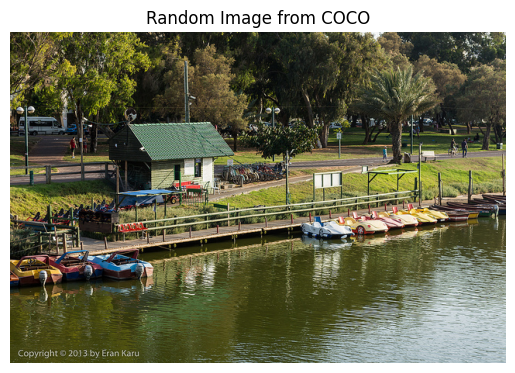

In [ ]:
all_img_ids = coco.getImgIds()
print(f"Total Images in COCO val2017: {len(all_img_ids)}")
img_ids_person = coco.getImgIds(catIds=[1])  # Person category
print(f"Images found for 'person': {len(img_ids_person)}")
import random
img_data = coco.loadImgs(random.choice(all_img_ids))[0]
image_path = os.path.join(coco_dir, "val2017", img_data["file_name"])
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.title("Random Image from COCO")
plt.axis("off")
plt.show()


In [ ]:
# Load all category names and IDs
categories = coco.loadCats(coco.getCatIds())
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")
# Get all animal-related categories
animal_categories = ['cat', 'dog', 'horse', 'cow', 'elephant', 'bear']
cat_ids = coco.getCatIds(catNms=animal_categories)

# Get images with these animals
img_ids = coco.getImgIds(catIds=cat_ids)

if not img_ids:
    raise ValueError("No images found with animals in COCO dataset!")

# Pick a random image with an animal
import random
img_data = coco.loadImgs(random.choice(img_ids))[0]

# Load the image
image_path = os.path.join(coco_dir, "val2017", img_data["file_name"])
image = Image.open(image_path).convert("RGB")

# Show the image
plt.imshow(image)
plt.title("Random Animal Image from COCO")
plt.axis("off")
plt.show()


ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup
ID: 48, Name: fork
ID: 49, Name: knife
ID: 50, Name: spoon
ID: 51, Name: bowl
ID: 5

ValueError: No images found with animals in COCO dataset!